# Assignmnet 3 (100 + 5 points)

**Name:** Dev Bhanushali<br>
**Email:** deb3962@thi.de<br>
**Group:** A <br>
**Hours spend *(optional)* : 10-15 Hrs** <br>

### Question 1: Transformer model *(100 points)*

As a Machine Learning engineer at a tech company, you were given a task to develop a machine translation system that translates **English (source) to German (Target)**. You can use existing libraries but the training needs to be done from scratch (usage of pretrained weights is not allowed). You have the freedom to select any dataset for training the model. Use a small subset of data as a validation dataset and report the BLEU score on the validation set. Also, provide a short description of your transformer model architecture, hyperparameters, and training (also provide the training loss curve).

<h3> Submission </h3>

The test set **(test.txt)** will be released one week before the deadline. You should submit the output of your model on the test set separately. Name the output file as **"first name_last_name_test_result.txt"**. Each line of the submission file should contain only the translated text of the corresponding sentence from 'test.txt'.

The 'first name_last_name_test_result.txt' file will be evaluated by your instructor and the student who could get the best BLEU score will get 5 additional points. 

**Dataset**

Here are some of the parallel datasets (see Datasets and Resources file):
* Europarl Parallel corpus - https://www.statmt.org/europarl/v7/de-en.tgz
* News Commentary - https://www.statmt.org/wmt14/training-parallel-nc-v9.tgz (use DE-EN parallel data)
* Common Crawl corpus - https://www.statmt.org/wmt13/training-parallel-commoncrawl.tgz (use DE-EN parallel data)

You can also use other datasets of your choice. In the above datasets, **'.en'** file has the text in English, and **'.de'** file contains their corresponding German translations.

## Notes:

1) You can also consider using a small subset of the dataset if the training dataset is large
2) Sometimes you can also get out of memory errors while training, so choose the hyperparameters carefully.
3) Your training will be much faster if you use a GPU. If you are using a CPU, it may take several hours or even days. (you can also use Google Colab GPUs for training. link: https://colab.research.google.com/)

## Comments on this work

#### <b>Architecture</b>
The transformer architecture used for this assignment is the same as the one used in <a href=”https://arxiv.org/pdf/1706.03762”>[1706.03762] Attention Is All You Need</a>

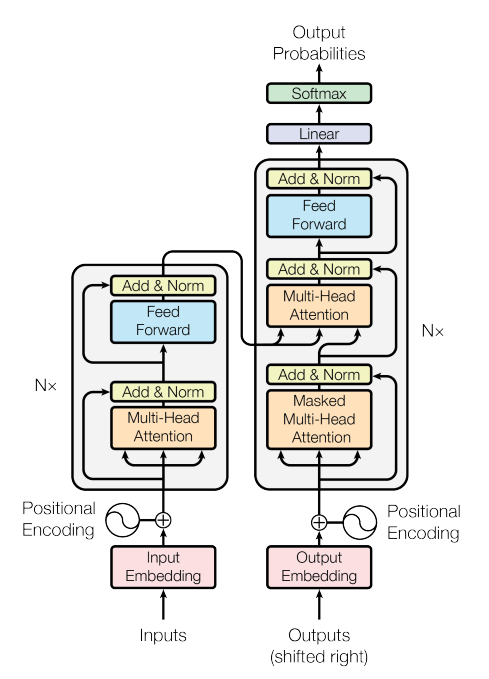

Data is tokenized using the <b>Scapy</b> pretrained tokenizer. We further perform sinusoidal positional encoding on the word embeddings.<br>
Masks are also generated to complement the teacher forcing method to train the transformer faster.

#### <b> Hyper Parameters </b>
Embedding Size: 512<br>
Heads: 8<br>
Feed Forward Hidden Layer Size: 512<br>
Batch Size: 128<br>
Encoder Decoder Layers: 6<br>

#### <b>Training - Validation Loss Curves</b> (Also shown below in the <b>Evaluation</b> section)
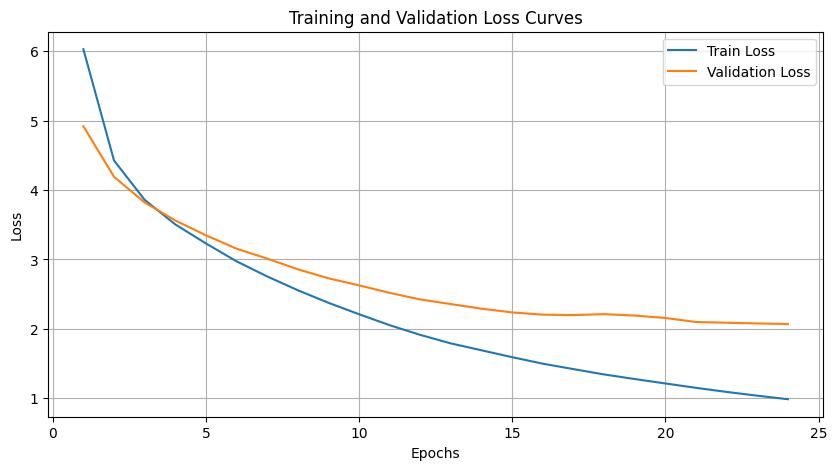

#### <b>Specs</b>

CPU: Intel i9-13980HX<br>
GPU: Nvidia RTX 4090 Laptop GPU - DDR5<br>
Ram: 2 x 16 GB DDR5 5600Mhz<br>

## Imports

In [2]:
import torch
torch.utils.data.datapipes.utils.common.DILL_AVAILABLE = torch.utils._import_utils.dill_available()

import math
import torch.nn as nn
from torch import Tensor
from torch.nn import Transformer
from typing import Iterable, List
from torch.utils.data import DataLoader
from timeit import default_timer as timer
from torch.nn.utils.rnn import pad_sequence
from torchtext.data.utils import get_tokenizer
from torchtext.datasets import multi30k, Multi30k
from nltk.translate.bleu_score import corpus_bleu
from torchtext.vocab import build_vocab_from_iterator
multi30k.URL["train"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/training.tar.gz"
multi30k.URL["valid"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/validation.tar.gz"

c:\Users\devbh\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchtext\data\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
c:\Users\devbh\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchtext\datasets\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
c:\Users\devbh\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchte

gpu check

In [3]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

1
NVIDIA GeForce RTX 4090 Laptop GPU


## Util functions for Data Loading

importing data

In [4]:
token_transform = {}
vocab_transform = {}

TGT_LANGUAGE, SRC_LANGUAGE = 'de', 'en'

# load tokenizers
token_transform[SRC_LANGUAGE], token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm'), get_tokenizer('spacy', language='en_core_web_sm')

# set special symbol indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

def yield_tokens(data_iter: Iterable, language: str):
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}
    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln), min_freq=1, specials=special_symbols, special_first=True)

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  vocab_transform[ln].set_default_index(UNK_IDX)

## Transformer Architecture

Transformer Architecture

In [5]:
# Positional encoding
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()


        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        
        # initialize matrix embedding
        embed_pos = torch.zeros((maxlen, emb_size))
        
        # alternatively place sin and cosine delta constants
        embed_pos[:, 0::2] = torch.sin(pos * den)
        embed_pos[:, 1::2] = torch.cos(pos * den)
        embed_pos = embed_pos.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('embed_pos', embed_pos)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.embed_pos[:token_embedding.size(0), :])

# encode tensor input indices to tensor of token embedding
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

# Transformer architecture
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

generating masks for sequences

In [6]:
def generateMask(src, tgt):
    src_seq_len, tgt_seq_len = src.shape[0], tgt.shape[0]
    tgt_mask, src_mask = generateNextSquareMask(tgt_seq_len), torch.zeros((src_seq_len, src_seq_len), device=DEVICE).type(torch.bool)
    src_padding_mask, tgt_padding_mask = (src == PAD_IDX).transpose(0, 1), (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

def generateNextSquareMask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


setting up transformer instance on gpu with archetecture hyperparameters

In [7]:
SRC_VOCAB_SIZE, TGT_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE]), len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE, NHEAD, FFN_HID_DIM, BATCH_SIZE, NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS = 512, 8, 512, 128, 6, 6

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE, NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)
for p in transformer.parameters():
    if p.dim() > 1: nn.init.xavier_uniform_(p)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)
transformer = transformer.to(DEVICE)

c:\Users\devbh\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
c:\Users\devbh\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Pre - Processing

pre-processing sequence data into tensors

In [8]:
# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms: txt_input = transform(txt_input)
        return txt_input
    return func

# add begin of sentence and end of sentence tensors to each sequence
def tensor_transform(token_ids: List[int]): return torch.cat((torch.tensor([BOS_IDX]), torch.tensor(token_ids), torch.tensor([EOS_IDX])))

# convert raw strings to tensor sequences with bos and eos tokens
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]: text_transform[ln] = sequential_transforms(token_transform[ln], vocab_transform[ln], tensor_transform) # Add BOS/EOS and create tensor

# convert data samples into batch tensors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))
    src_batch, tgt_batch = pad_sequence(src_batch, padding_value=PAD_IDX), pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch


## Training

In [9]:
# train and get training score
def train_epoch(model, optimizer):
    model.train()
    losses = 0
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)
    for src, tgt in train_dataloader:
        src, tgt = src.to(DEVICE), tgt.to(DEVICE)
        tgt_input = tgt[:-1, :]
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = generateMask(src, tgt_input)
        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)
        optimizer.zero_grad()
        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()
        optimizer.step()
        losses += loss.item()
    return losses / len(list(train_dataloader))


# val test and get testing score
def evaluate(model):
    model.eval()
    losses = 0
    val_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)
    for src, tgt in val_dataloader:
        src, tgt = src.to(DEVICE), tgt.to(DEVICE)
        tgt_input = tgt[:-1, :]
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = generateMask(src, tgt_input)
        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)
        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()
    return losses / len(list(val_dataloader))


## Evaluation

In [ ]:
# old results

# Epoch: 1, Train loss: 6.030, Val loss: 4.919, Epoch time = 33.900s
# Epoch: 2, Train loss: 4.426, Val loss: 4.191, Epoch time = 34.678s
# Epoch: 3, Train loss: 3.859, Val loss: 3.821, Epoch time = 34.680s
# Epoch: 4, Train loss: 3.505, Val loss: 3.562, Epoch time = 34.593s
# Epoch: 5, Train loss: 3.231, Val loss: 3.348, Epoch time = 34.684s
# Epoch: 6, Train loss: 2.973, Val loss: 3.155, Epoch time = 34.728s
# Epoch: 7, Train loss: 2.755, Val loss: 3.012, Epoch time = 34.772s
# Epoch: 8, Train loss: 2.556, Val loss: 2.858, Epoch time = 35.046s
# Epoch: 9, Train loss: 2.375, Val loss: 2.728, Epoch time = 34.899s
# Epoch: 10, Train loss: 2.210, Val loss: 2.626, Epoch time = 34.875s
# Epoch: 11, Train loss: 2.052, Val loss: 2.518, Epoch time = 34.766s
# Epoch: 12, Train loss: 1.912, Val loss: 2.423, Epoch time = 34.636s
# Epoch: 13, Train loss: 1.789, Val loss: 2.356, Epoch time = 35.038s
# Epoch: 14, Train loss: 1.690, Val loss: 2.290, Epoch time = 35.041s
# Epoch: 15, Train loss: 1.591, Val loss: 2.236, Epoch time = 34.995s
# Epoch: 16, Train loss: 1.497, Val loss: 2.204, Epoch time = 35.062s
# Epoch: 17, Train loss: 1.419, Val loss: 2.198, Epoch time = 35.154s
# Epoch: 18, Train loss: 1.342, Val loss: 2.211, Epoch time = 34.992s
# Epoch: 19, Train loss: 1.276, Val loss: 2.191, Epoch time = 34.876s
# Epoch: 20, Train loss: 1.212, Val loss: 2.156, Epoch time = 35.040s
# Epoch: 21, Train loss: 1.149, Val loss: 2.098, Epoch time = 34.895s
# Epoch: 22, Train loss: 1.090, Val loss: 2.088, Epoch time = 34.889s
# Epoch: 23, Train loss: 1.036, Val loss: 2.077, Epoch time = 35.073s
# Epoch: 24, Train loss: 0.985, Val loss: 2.069, Epoch time = 35.024s
# Epoch: 25, Train loss: 0.939, Val loss: 2.076, Epoch time = 34.987s
# Epoch: 26, Train loss: 0.899, Val loss: 2.083, Epoch time = 35.114s
# Epoch: 27, Train loss: 0.852, Val loss: 2.093, Epoch time = 34.957s
# Epoch: 28, Train loss: 0.813, Val loss: 2.088, Epoch time = 35.105s
# Epoch: 29, Train loss: 0.775, Val loss: 2.108, Epoch time = 34.948s
# Epoch: 30, Train loss: 0.738, Val loss: 2.094, Epoch time = 34.970s
# Epoch: 31, Train loss: 0.698, Val loss: 2.097, Epoch time = 34.902s
# Epoch: 32, Train loss: 0.661, Val loss: 2.107, Epoch time = 34.790s
# Epoch: 33, Train loss: 0.630, Val loss: 2.136, Epoch time = 34.962s
# Epoch: 34, Train loss: 0.598, Val loss: 2.152, Epoch time = 35.065s
# Epoch: 35, Train loss: 0.567, Val loss: 2.186, Epoch time = 35.007s
# Epoch: 36, Train loss: 0.540, Val loss: 2.199, Epoch time = 35.307s
# Epoch: 37, Train loss: 0.517, Val loss: 2.235, Epoch time = 35.087s
# Epoch: 38, Train loss: 0.491, Val loss: 2.246, Epoch time = 34.943s
# Epoch: 39, Train loss: 0.462, Val loss: 2.245, Epoch time = 35.096s
# Epoch: 40, Train loss: 0.440, Val loss: 2.278, Epoch time = 34.942s
# Epoch: 41, Train loss: 0.416, Val loss: 2.344, Epoch time = 34.911s
# Epoch: 42, Train loss: 0.396, Val loss: 2.326, Epoch time = 34.910s
# Epoch: 43, Train loss: 0.373, Val loss: 2.355, Epoch time = 35.258s
# Epoch: 44, Train loss: 0.354, Val loss: 2.377, Epoch time = 34.861s
# Epoch: 45, Train loss: 0.336, Val loss: 2.393, Epoch time = 35.147s
# Epoch: 46, Train loss: 0.319, Val loss: 2.417, Epoch time = 35.039s
# Epoch: 47, Train loss: 0.299, Val loss: 2.466, Epoch time = 34.958s
# Epoch: 48, Train loss: 0.282, Val loss: 2.494, Epoch time = 34.989s
# Epoch: 49, Train loss: 0.268, Val loss: 2.490, Epoch time = 35.231s
# Epoch: 50, Train loss: 0.257, Val loss: 2.531, Epoch time = 34.896s
# Epoch: 51, Train loss: 0.246, Val loss: 2.537, Epoch time = 34.821s
# Epoch: 52, Train loss: 0.234, Val loss: 2.574, Epoch time = 34.825s
# Epoch: 53, Train loss: 0.224, Val loss: 2.615, Epoch time = 35.018s
# Epoch: 54, Train loss: 0.214, Val loss: 2.611, Epoch time = 35.077s
# Epoch: 55, Train loss: 0.205, Val loss: 2.628, Epoch time = 34.940s
# Epoch: 56, Train loss: 0.196, Val loss: 2.623, Epoch time = 35.033s
# Epoch: 57, Train loss: 0.187, Val loss: 2.634, Epoch time = 35.096s
# Epoch: 58, Train loss: 0.177, Val loss: 2.653, Epoch time = 35.158s
# Epoch: 59, Train loss: 0.170, Val loss: 2.636, Epoch time = 35.053s
# Epoch: 60, Train loss: 0.161, Val loss: 2.688, Epoch time = 34.996s
# Epoch: 61, Train loss: 0.157, Val loss: 2.691, Epoch time = 34.922s
# Epoch: 62, Train loss: 0.150, Val loss: 2.699, Epoch time = 34.927s
# Epoch: 63, Train loss: 0.143, Val loss: 2.711, Epoch time = 34.950s
# Epoch: 64, Train loss: 0.139, Val loss: 2.747, Epoch time = 34.863s
# Epoch: 65, Train loss: 0.133, Val loss: 2.773, Epoch time = 34.875s
# Epoch: 66, Train loss: 0.129, Val loss: 2.777, Epoch time = 35.394s
# Epoch: 67, Train loss: 0.124, Val loss: 2.786, Epoch time = 35.013s
# Epoch: 68, Train loss: 0.118, Val loss: 2.799, Epoch time = 34.953s
# Epoch: 69, Train loss: 0.114, Val loss: 2.795, Epoch time = 35.025s
# Epoch: 70, Train loss: 0.109, Val loss: 2.805, Epoch time = 34.948s
# Epoch: 71, Train loss: 0.107, Val loss: 2.823, Epoch time = 35.057s
# Epoch: 72, Train loss: 0.101, Val loss: 2.845, Epoch time = 34.997s
# Epoch: 73, Train loss: 0.099, Val loss: 2.821, Epoch time = 35.064s
# Epoch: 74, Train loss: 0.095, Val loss: 2.855, Epoch time = 35.137s
# Epoch: 75, Train loss: 0.092, Val loss: 2.893, Epoch time = 35.190s
# Epoch: 76, Train loss: 0.091, Val loss: 2.865, Epoch time = 35.150s
# Epoch: 77, Train loss: 0.086, Val loss: 2.891, Epoch time = 35.208s
# Epoch: 78, Train loss: 0.083, Val loss: 2.893, Epoch time = 35.236s
# Epoch: 79, Train loss: 0.081, Val loss: 2.896, Epoch time = 35.159s
# Epoch: 80, Train loss: 0.080, Val loss: 2.912, Epoch time = 35.170s
# Epoch: 81, Train loss: 0.076, Val loss: 2.903, Epoch time = 35.340s
# Epoch: 82, Train loss: 0.074, Val loss: 2.953, Epoch time = 35.177s
# Epoch: 83, Train loss: 0.072, Val loss: 2.946, Epoch time = 35.285s
# Epoch: 84, Train loss: 0.070, Val loss: 2.953, Epoch time = 35.356s
# Epoch: 85, Train loss: 0.068, Val loss: 2.934, Epoch time = 35.594s
# Epoch: 86, Train loss: 0.066, Val loss: 2.958, Epoch time = 34.910s
# Epoch: 87, Train loss: 0.066, Val loss: 2.994, Epoch time = 35.257s
# Epoch: 88, Train loss: 0.063, Val loss: 2.993, Epoch time = 35.809s
# Epoch: 89, Train loss: 0.062, Val loss: 2.999, Epoch time = 35.024s
# Epoch: 90, Train loss: 0.059, Val loss: 3.001, Epoch time = 35.044s
# Epoch: 91, Train loss: 0.058, Val loss: 3.053, Epoch time = 35.422s
# Epoch: 92, Train loss: 0.057, Val loss: 3.072, Epoch time = 36.464s
# Epoch: 93, Train loss: 0.055, Val loss: 3.073, Epoch time = 36.489s
# Epoch: 94, Train loss: 0.055, Val loss: 3.053, Epoch time = 36.655s
# Epoch: 95, Train loss: 0.053, Val loss: 3.060, Epoch time = 36.113s
# Epoch: 96, Train loss: 0.050, Val loss: 3.077, Epoch time = 35.800s
# Epoch: 97, Train loss: 0.050, Val loss: 3.097, Epoch time = 36.179s
# Epoch: 98, Train loss: 0.048, Val loss: 3.114, Epoch time = 36.577s
# Epoch: 99, Train loss: 0.047, Val loss: 3.114, Epoch time = 36.240s
# Epoch: 100, Train loss: 0.047, Val loss: 3.103, Epoch time = 37.015s

In [10]:
NUM_EPOCHS = 24

for epoch in range(1, NUM_EPOCHS + 1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer)
    end_time = timer()
    val_loss = evaluate(transformer)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))
    torch.cuda.empty_cache()


# generate output sequence
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generateNextSquareMask(ys.size(0)).type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()
        ys = torch.cat([ys, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys


# actual function to translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1).to(DEVICE)  # Move src tensor to device
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool).to(DEVICE)  # Move src_mask tensor to device
    tgt_tokens = greedy_decode(model, src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")


c:\Users\devbh\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
c:\Users\devbh\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
c:\Users\devbh\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\datapipes\iter\combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


Epoch: 1, Train loss: 6.030, Val loss: 4.919, Epoch time = 32.250s
Epoch: 2, Train loss: 4.426, Val loss: 4.191, Epoch time = 34.463s
Epoch: 3, Train loss: 3.859, Val loss: 3.821, Epoch time = 35.960s
Epoch: 4, Train loss: 3.505, Val loss: 3.562, Epoch time = 35.788s
Epoch: 5, Train loss: 3.231, Val loss: 3.348, Epoch time = 35.772s
Epoch: 6, Train loss: 2.973, Val loss: 3.155, Epoch time = 35.687s
Epoch: 7, Train loss: 2.755, Val loss: 3.012, Epoch time = 35.039s
Epoch: 8, Train loss: 2.556, Val loss: 2.858, Epoch time = 35.086s
Epoch: 9, Train loss: 2.375, Val loss: 2.728, Epoch time = 34.966s
Epoch: 10, Train loss: 2.210, Val loss: 2.626, Epoch time = 34.958s
Epoch: 11, Train loss: 2.052, Val loss: 2.518, Epoch time = 34.817s
Epoch: 12, Train loss: 1.912, Val loss: 2.423, Epoch time = 35.085s
Epoch: 13, Train loss: 1.789, Val loss: 2.356, Epoch time = 35.362s
Epoch: 14, Train loss: 1.690, Val loss: 2.290, Epoch time = 35.218s
Epoch: 15, Train loss: 1.591, Val loss: 2.236, Epoch time

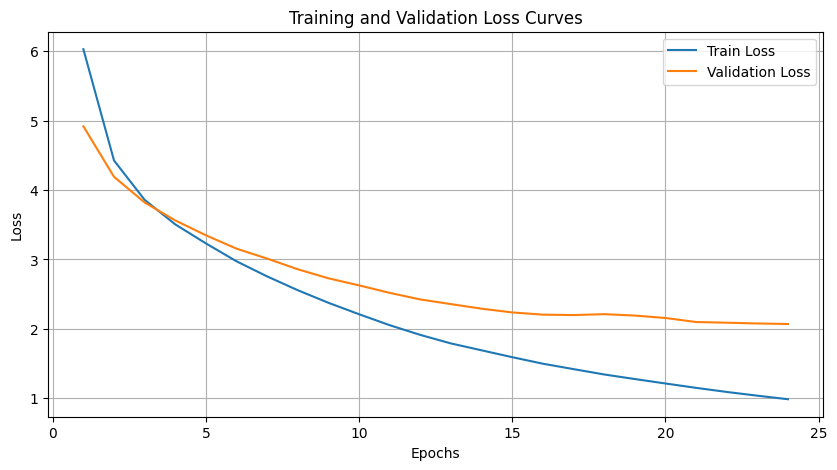

In [10]:
import matplotlib.pyplot as plt

epochs = list(range(1, 25))
train_loss = [6.030, 4.426, 3.859, 3.505, 3.231, 2.973, 2.755, 2.556, 2.375, 2.210, 2.052, 1.912, 1.789, 1.690, 1.591, 1.497, 1.419, 1.342, 1.276, 1.212, 1.149, 1.090, 1.036, 0.985]
val_loss = [4.919, 4.191, 3.821, 3.562, 3.348, 3.155, 3.012, 2.858, 2.728, 2.626, 2.518, 2.423, 2.356, 2.290, 2.236, 2.204, 2.198, 2.211, 2.191, 2.156, 2.098, 2.088, 2.077, 2.069]

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs'), plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()


the german.txt file is the google translated content of test.en

In [13]:
sentences_en = []
sentences_de = []
predicted_de = []

with open("./test/english.txt", "r", encoding="utf-8") as f:
    sentences_en = f.readlines()

with open("./test/german.txt", "r", encoding="utf-8") as f:
    sentences_de = f.readlines()

for sample in sentences_en:
    predicted_de.append(translate(transformer, sample))

with open("./test/pred_24.txt", "wb") as f:
    f.writelines([x.encode('utf-8') for x in '\n'.join(predicted_de)])

In [12]:
tokenizer = get_tokenizer('spacy', language='en_core_web_sm')
def load_sentences(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()
    return [line.strip() for line in lines]

reference_file = "./test/german.txt"
candidate_file = "./test/Dev_Bhanushali_test_result.txt"

reference_sentences = load_sentences(reference_file)
candidate_sentences = load_sentences(candidate_file)

reference_tokenized = [tokenizer(sentence) for sentence in reference_sentences]
candidate_tokenized = [tokenizer(sentence) for sentence in candidate_sentences]

bleu_score = corpus_bleu([[ref] for ref in reference_tokenized], candidate_tokenized)
print("BLEU Score on Validation Dataset:", round(bleu_score, 2))

BLEU Score on Validation Dataset: 0.25
